In [183]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from numba.cuda.cudaimpl import ptx_min_f4
from scipy.linalg import signm

from scipy.special import erf
from scipy.optimize import curve_fit

from config.plotting import set_plotting_defaults, orangered_palette, save_figure
from config.units import Gauss

In [184]:
def diffusion_coefficient(energy, bfield):
    return 1e30 * u.cm**2 / u.s * (energy / u.PeV / bfield * 1e-6 * Gauss)**(1/3)

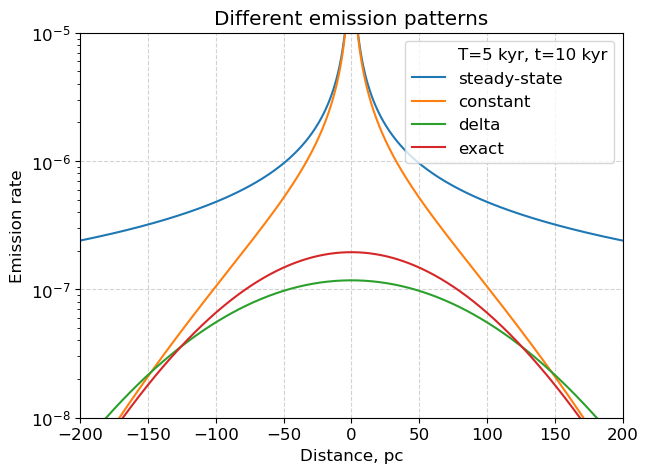

In [255]:
set_plotting_defaults()

r = np.linspace(-300, 300, 1000) * u.pc
r1 = np.abs(r)
e1 = 1e12 * u.eV  # 1 TeV
bf1 = 1e-6 * Gauss  # 1 uG

t = 10000 * u.yr
T = 5000 * u.yr

q = 1/T

plt.title("Different emission patterns")
dc = diffusion_coefficient(e1, bf1).to(u.pc**2 / u.yr)
plt.plot(1, 1, linestyle='None', label=f'T={T.value * 1e-3:.0f} kyr, t={t.value * 1e-3:.0f} kyr', color='black')
plt.plot(r, q/(4 * np.pi * dc * r1), label='steady-state')
plt.plot(r, q/(4 * np.pi * dc * r1) * (1 - erf(r1/np.sqrt(4 * dc * t))), label='constant')
plt.plot(r, q * T/(4 * np.pi * dc * t)**1.5 * np.exp(- r**2 / (4 * dc * t)), label='delta')
plt.plot(r, q/(4 * np.pi * dc * r1) * (erf(r1/np.sqrt(4 * dc * (t-T))) - erf(r1/np.sqrt(4 * dc * t))), label='exact')

plt.xlim(-200, 200)
plt.xlabel("Distance, pc")
plt.ylim(1e-8, 1e-5)
plt.ylabel("Emission rate")
plt.yscale('log')
plt.legend()
plt.show()

In [186]:
y_HESS = 115 * np.array([-0.6432652733138268, -0.47918361452508335, -0.31387755463491746, -0.15224481482547125, 0.04122457237355248, 0.18938796585573325, 0.35102047211227494, 0.5151021309010184, 0.6791837896897619, 0.8444899663563801])
dNdE_HESS = np.array([0.5494506415818844, 0.038461377231703106, 0.9230769835381114, 1.2472529459109374, 0.9890109976483014, 1.0879122808120698, 1.4835166274716938, 0.6483516627471692, 0.5879120188135875, -0.28022047696299673])
total = np.trapezoid(dNdE_HESS, y_HESS)
print(f"N = {total:.0f}")

N = 136


In [187]:
e1 = 1e12 * u.eV  # 1 TeV
bf1 = 1e-6 * Gauss  # 1 muG
dif_cof = diffusion_coefficient(e1, bf1).to(u.pc**2 / u.yr).value

In [188]:
def profile_1d(y_signed, a, b):
    T1 = 10**a
    delta_t = 10**b
    t1 = T1 + delta_t
    y0 = np.abs(y_signed)
    q1 = total / T1

    erf_part = y0 * np.sqrt(np.pi) * (erf(y0 / np.sqrt(4 * dif_cof * t1)) - erf(y0 / np.sqrt(4 * dif_cof * delta_t)))
    exp_part_1 = np.sqrt(4 * dif_cof * t1) * np.exp(-y0 ** 2 / (4 * dif_cof * t1))
    exp_part_2 = np.sqrt(4 * dif_cof * delta_t) * np.exp(-y0**2 / (4 * dif_cof * delta_t))
    value = q1 / (2 * np.sqrt(np.pi) * dif_cof)
    return value * (exp_part_1 - exp_part_2 + erf_part)


In [189]:
set_plotting_defaults()

res, pcov = curve_fit(profile_1d, y_HESS, dNdE_HESS, sigma=0.25, bounds=[[-3, -3], [6, 8]], p0=[2, 4])
print(f"optimal: {res}")
err = np.sqrt(np.diag(pcov))
print(f"errors: {err}")

optimal: [1.23118357 3.48745111]
errors: [59257.04264384   163.93111432]


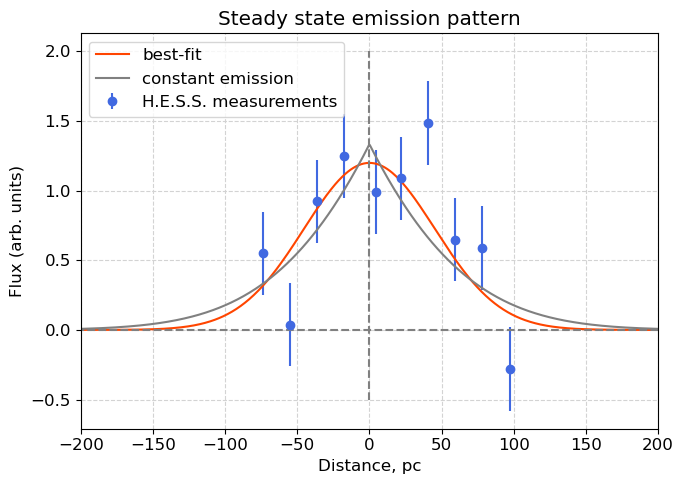

In [252]:
set_plotting_defaults()
plt.title("Steady state emission pattern")

plt.errorbar(y_HESS, dNdE_HESS, yerr=0.3, linestyle='None', marker='o', color='royalblue', label='H.E.S.S. measurements')

ys = np.linspace(-300, 300, 1000)

fitted_x = profile_1d(y_HESS, *res)
fitted_r = profile_1d(ys, *res)

# plt.plot(ys, fitted_r, color='orangered')
plt.plot(ys, profile_1d(ys, 0.0, 3.49), color='orangered', label='best-fit')
plt.plot(ys, profile_1d(ys, 4, -5), color='gray', label='constant emission')

plt.plot(r, np.zeros_like(r), color='grey', linestyle='dashed')
plt.plot([0, 0], [-0.5, 2.0], color='grey', linestyle='dashed')

plt.xlim(-200, 200)
plt.xlabel("Distance, pc")
# plt.ylim(-0.5, 2)
plt.ylabel("Flux (arb. units)")

plt.legend(loc=2)
plt.tight_layout()
save_figure("steady_state_fit")
plt.show()

# Statistical analysis

In [191]:
def get_chi2(model1, data1, data_error1):
    return np.sum((model1 - data1)**2 / data_error1**2, axis=0)

In [192]:
grid_a = np.linspace(0, 6, 350)  # lg T
grid_b = np.linspace(0, 7, 400)  # lg delta_T
ab, ba = np.meshgrid(grid_a, grid_b, indexing='ij')

ones = np.ones_like(ab)
model = np.array([profile_1d(y_i, ab, ba) for y_i in y_HESS])
data = np.array([d_i * ones for d_i in dNdE_HESS])
chi2 = get_chi2(model, data, 0.3)

In [210]:
print(np.min(chi2))
min_index_flat = np.argmin(chi2)
min_position = np.unravel_index(min_index_flat, np.shape(chi2), 'C')
print(grid_a[min_position[0]], grid_b[min_position[1]])
min_position

12.680904991098418
0.0 3.4912280701754383


(np.int64(0), np.int64(199))

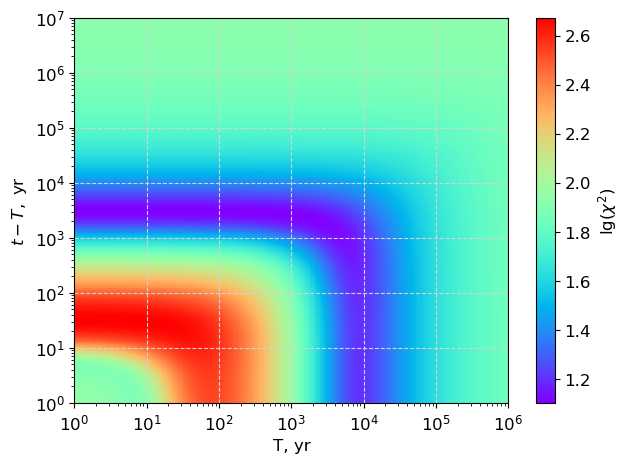

In [211]:
mesh = plt.pcolormesh(10**grid_a, 10**grid_b, np.log10(chi2.T), shading='nearest', cmap='rainbow')
plt.ylabel("$t - T,$ yr")
plt.ylim(1e0, 1e7)
plt.yscale('log')
plt.xlabel("T, yr" )
plt.xlim(1e0, 1e6)
plt.xscale('log')
plt.colorbar(mesh, label=r'$\lg(\chi^2)$')
plt.show()

### Now we're looking for a lower limit for $t$

Gaussian:
$$ p(r) = \dfrac{1}{\sqrt{2\pi}}e^{-r^2/2}$$
$$ P(r) = \intop_{-\infty}^{x}p(r^2)dr = \dfrac{1}{\sqrt{2\pi}} \intop_{-\infty}^{r}e^{-\rho^2/2}d\rho = \dfrac{1 + \mathrm{erf}(r/\sqrt{2})}{2} $$

3.8409602400600154


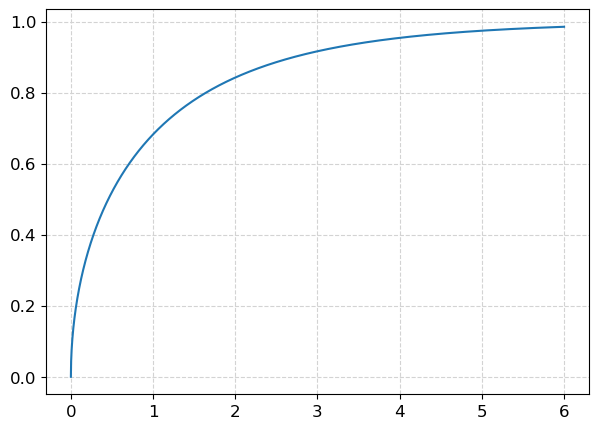

In [212]:
import scipy.stats as sps

x = np.linspace(0, 6, 4000)

chi2_cdf = sps.chi2.cdf(x, df=1)
plt.plot(x, chi2_cdf)
print(x[np.argmin(np.abs(chi2_cdf - 0.95))])

95% lower limit is 0.0
90% lower limit is 2.07
68% lower limit is 2.88


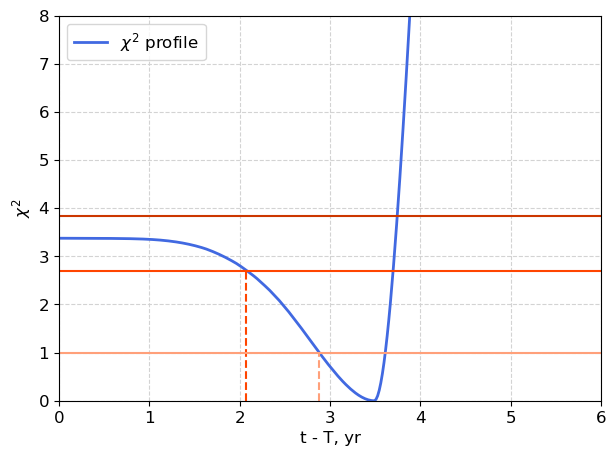

In [213]:
chi2_profile = np.min(chi2, axis=0)[1:] - np.min(chi2)
i_max = np.argmin(chi2_profile)

quant_95 = x[np.argmin(np.abs(chi2_cdf - 0.95))]
quant_90 = x[np.argmin(np.abs(chi2_cdf - 0.90))]
quant_68 = x[np.argmin(np.abs(chi2_cdf - 0.68))]

plt.plot(grid_b[1:], chi2_profile, linewidth=2, color="royalblue", label=r"$\chi^2$"" profile")

# 95% quantile
plt.plot(grid_b[1:], quant_95 * np.ones_like(chi2_profile), color=orangered_palette[2])
print(f"95% lower limit is 0.0")

# 90% quantile
plt.plot(grid_b[1:], quant_90 * np.ones_like(chi2_profile), color=orangered_palette[1])
lower_90 = grid_b[1:][np.argmin(np.abs(chi2_profile[:i_max] - quant_90))]
plt.plot([lower_90, lower_90], [0, quant_90], color=orangered_palette[1], linestyle='dashed')
print(f"90% lower limit is {lower_90:.2f}")

# 68% quantile
plt.plot(grid_b[1:], quant_68 * np.ones_like(chi2_profile), color=orangered_palette[0])
lower_68 = grid_b[1:][np.argmin(np.abs(chi2_profile[:i_max] - quant_68))]
plt.plot([lower_68, lower_68], [0, quant_68], color=orangered_palette[0], linestyle='dashed')
print(f"68% lower limit is {lower_68:.2f}")

plt.ylim(0, 8)
plt.xlim(0, 6)
plt.xlabel("t - T, yr")
plt.ylabel(r"$\chi^2$")
plt.legend(loc=2)
plt.plot([])
plt.show()

# Geometrical analysis

In [214]:
def profile(rx, T1, delta_t1):
    q1 = total / T1
    t1 = T1 + delta_t1
    return q1 / (4 * np.pi * dif_cof * rx) * (erf(rx / np.sqrt(4 * dif_cof * delta_t1)) - erf(rx / np.sqrt(4 * dif_cof * t1)))

### Simply curved line

In [198]:
T = 2
t = 1500

x = np.linspace(-400, 400, 200)
y = np.linspace(-400, 400, 200)
dy = y[1] - y[0]
z = np.linspace(-400, 400, 200)
dz = z[1] - z[0]

dif_ratio = 5

In [199]:
xy, yx = np.meshgrid(x, y, indexing='ij')

profile_tot = np.zeros_like(xy)
alpha = np.deg2rad(60)

for k in range(len(z)):
    shift = (xy * np.cos(alpha) - z[k] * np.sin(alpha))
    z_k = xy * np.sin(alpha) + z[k] * np.cos(alpha)
    left_part = np.sqrt(shift**2 + dif_ratio * (y**2 + z_k**2))
    right_part = np.sqrt(xy**2 + dif_ratio * (y**2 + z[k]**2))
    r_k = np.sqrt(left_part * np.heaviside(-xy, 0.5) + right_part * np.heaviside(xy, 0.5))
    profile_tot += profile(r_k, t, t-T) * dz

In [200]:
xz, zx = np.meshgrid(x, z, indexing='ij')

profile_z = np.zeros_like(xz)

for j in range(len(y)):
    shift = xz * np.cos(alpha) - zx * np.sin(alpha)
    z_k = xz * np.sin(alpha) + zx * np.cos(alpha)
    left_part = np.sqrt(shift**2 + dif_ratio * (y[j]**2 + z_k**2))
    right_part = np.sqrt(xz**2 + dif_ratio * (y[j]**2 + zx**2))
    r_k = np.sqrt(left_part * np.heaviside(-xz, 0.5) + right_part * np.heaviside(xz, 0.5))
    profile_z += profile(r_k, t, t-T) * dy

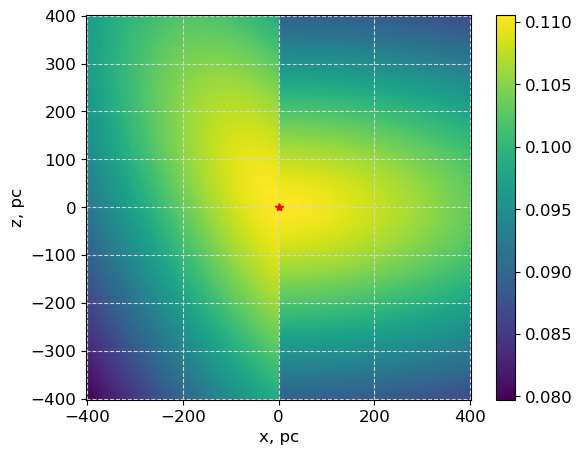

In [201]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.pcolormesh(xz, zx, profile_z)
plt.plot(0, 0, "r*")
plt.colorbar()
plt.xlabel("x, pc")
plt.ylabel("z, pc")
plt.gca().set_aspect('equal')

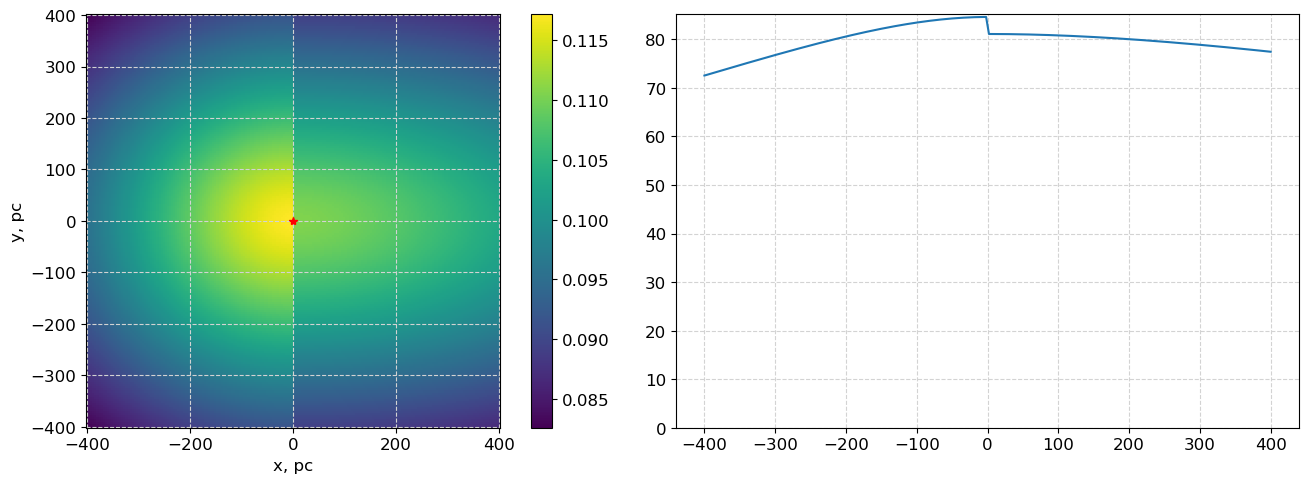

31909.489762267225
31971.384899525976


In [202]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.pcolormesh(xy, yx, profile_tot)
plt.plot(0, 0, "r*")
plt.colorbar()
plt.gca().set_aspect('equal')
plt.xlabel("x, pc")
plt.ylabel("y, pc")

plt.subplot(122)
ans = np.trapezoid(profile_tot, y)
plt.plot(x, ans)
plt.ylim(0)
plt.tight_layout()
plt.show()

print(np.trapezoid(ans * (x>=0), x))
print(np.trapezoid(ans * (x<=0), x))

### A constantly-curved line

In [249]:
x = np.linspace(-200, 200, 180)  # along the line of sight
y = np.linspace(-200, 200, 190)  # along the nebula
z = np.linspace(-200, 200, 200)  # orth to the nebula in the celestial sphere

T = 1
delta_t = np.exp(3.49 * np.log(10)) * 2

dif_ratio = 25

xy, yx = np.meshgrid(x, y, indexing='ij')
yz, zy = np.meshgrid(y, z, indexing='ij')

R0 = 150
cos_alpha = -3/4
sin_alpha = np.sqrt(1 - cos_alpha**2)
center = R0 * np.array([sin_alpha, cos_alpha])

profile_3D = np.zeros([180, 190, 200])

for k in range(len(z)):
    vp = np.array([yx - center[0], xy - center[1]])
    x2 = R0 - np.sqrt(vp[0]**2 + vp[1]**2)
    cos_beta = -(vp[0] * center[0] + vp[1] * center[1]) / (np.sqrt(np.sum(vp**2, axis=0)) * R0)
    y2 = R0 * np.arccos(cos_beta)
    r_k = np.sqrt(y2**2 + dif_ratio * (z[k]**2 + x2**2))
    profile_3D[:, :, k] = dif_ratio * profile(r_k, T, delta_t)


In [250]:
profile_xy = np.trapezoid(profile_3D, z, axis=2)
profile_yz = np.trapezoid(profile_3D, x, axis=0)

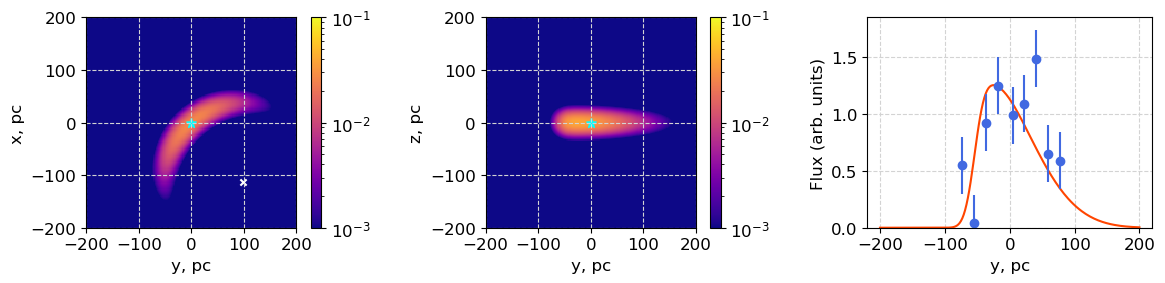

In [256]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.pcolormesh(yx, xy, profile_xy + 1e-32, cmap='plasma', rasterized=True, norm='log', vmax=1e-1, vmin=1e-3)
plt.colorbar()
plt.scatter(0, 0, color='cyan', marker="*", s=50)
plt.scatter(center[0], center[1], color='white', marker='x', s=20)
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.xlabel("y, pc")
plt.ylabel("x, pc")
plt.gca().set_aspect('equal')

plt.subplot(132)
plt.pcolormesh(yz, zy, profile_yz + 1e-32, cmap='plasma', rasterized=True, norm='log', vmax=1e-1, vmin=1e-3)
plt.colorbar()
plt.scatter(0, 0, color='cyan', marker="*", s=50)
plt.gca().set_aspect('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.xlabel("y, pc")
plt.ylabel("z, pc")

plt.subplot(133)
ans = np.trapezoid(profile_yz, z, axis=1)
plt.plot(y, ans, color='orangered')
plt.errorbar(y_HESS, dNdE_HESS, yerr=0.25, linestyle='None', marker='o',
             color='royalblue', label='H.E.S.S. measurements')
plt.xlabel("y, pc")
plt.ylabel("Flux (arb. units)")
plt.ylim(0)

plt.tight_layout()
save_figure("curved_source_profile")
plt.show()